In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [18]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [19]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Seperated", "Pyramid"], latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    n=-1
    for i, df in enumerate(df_list):
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [20]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption=""):
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    table = pd.crosstab(index=[df["sample_size"], df["method"]],
                columns=[df["latent_dimension"], df["item_dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", n={0}".format(n),
                             position="H"))
    return(table)

In [21]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+", n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

In [22]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 1104
Seperated Q sample size: 672
Pyramid Q sample size: 492


## Simulatuion Results

### Model Fit

In [7]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &        10 &        20 &       10 &       20 \\
\textbf{sample\_size} & \textbf{method} &           &           &          &          \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -176.040 &  -249.735 &  -198.01 &  -309.35 \\
    & \textbf{Initial Parameters} &  -217.040 &  -372.585 &  -271.99 &  -459.66 \\
    & \textbf{Late EM} &  -169.160 &  -251.435 &  -190.61 &  -286.84 \\
    & \textbf{Pure Competency} &  -171.900 &  -246.660 &  -199.86 &  -292.40 \\
    & \textbf{Real Param.} &  -181.350 &  -279.145 &  -213.33 &  -325.83 \\
    & \textbf{Real early Param.} &  -176.800 &  -258.495 &  -213.93 &  -303.90 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  -581.525 &  -899.870 &  -706.47 & -1042.18 \\
    & \textbf{Initial Parameters} &  -784.665 & -1103

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                       2                  3         
item_dimension                        10        20       10       20
sample_size method                                                  
30          Difference          -176.040  -249.735  -198.01  -309.35
            Initial Parameters  -217.040  -372.585  -271.99  -459.66
            Late EM             -169.160  -251.435  -190.61  -286.84
            Pure Competency     -171.900  -246.660  -199.86  -292.40
            Real Param.         -181.350  -279.145  -213.33  -325.83
            Real early Param.   -176.800  -258.495  -213.93  -303.90
100         Difference          -581.525  -899.870  -706.47 -1042.18
            Initial Parameters  -784.665 -1103.570  -946.06 -1506.30
            Late EM             -565.980  -894.870  -683.75 -1039.12
            Pure Competency     -577.265  -911.560  -715.32 -1050.26
            Real Param.         -600.880  -926.820  -729.25 -1090.54
            Real early Param.   -602.315  -905.540  -755.87 -1087.18
200         Difference         -1235.380 -1862.590 -1434.16 -2048.24
            Initial Parameters -1472.600 -2466.620 -1863.66 -2894.87
            Late EM            -1171.190 -1821.400 -1334.26 -2009.67
            Pure Competency    -1232.900 -1850.270 -1413.64 -2051.60
            Real Param.        -1246.310 -1883.040 -1455.01 -2046.65
            Real early Param.  -1285.230 -1853.210 -1512.73 -2078.04

In [23]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df])

\begin{table}[H]
\centering
\caption{, n=-1}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &    Full & Pyramid & Seperated &    Full & Pyramid & Seperated \\
\textbf{N} & \textbf{Method} &         &         &           &         &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -168.0 &  -161.0 &    -179.0 &  -219.0 &  -181.0 &    -253.0 \\
    & \textbf{Initial Parameters} &  -176.0 &  -174.0 &    -186.0 &  -300.0 &  -246.0 &    -359.0 \\
    & \textbf{Late EM} &  -168.0 &  -162.0 &    -179.0 &  -217.0 &  -204.0 &    -243.0 \\
    & \textbf{Pure Competency} &  -168.0 &  -161.0 &    -181.0 &  -226.0 &  -182.0 &    -246.0 \\
    & \textbf{Real Param.} &     NaN &     NaN &       NaN &  -245.0 &  -203.0 &    -255.0 \\
    & \textbf{Real early Param.} &     NaN &     NaN &       NaN &  -225.0 &  -206.0 &    -252.0 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \

/tmp/ipykernel_9483/1890911269.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit_table.to_latex(bold_rows=True, multirow=True,


Model                    Early                      Late                  
Q-type                    Full Pyramid Seperated    Full Pyramid Seperated
N   Method                                                                
30  Difference          -168.0  -161.0    -179.0  -219.0  -181.0    -253.0
    Initial Parameters  -176.0  -174.0    -186.0  -300.0  -246.0    -359.0
    Late EM             -168.0  -162.0    -179.0  -217.0  -204.0    -243.0
    Pure Competency     -168.0  -161.0    -181.0  -226.0  -182.0    -246.0
    Real Param.            NaN     NaN       NaN  -245.0  -203.0    -255.0
    Real early Param.      NaN     NaN       NaN  -225.0  -206.0    -252.0
100 Difference          -566.0  -798.0    -610.0  -771.0  -776.0    -841.0
    Initial Parameters  -582.0  -876.0    -623.0 -1010.0 -1090.0   -1142.0
    Late EM             -567.0  -796.0    -610.0  -737.0  -806.0    -821.0
    Pure Competency     -565.0  -801.0    -616.0  -761.0  -859.0    -824.0
    Real Param.            NaN     NaN       NaN  -783.0  -866.0    -832.0
    Real early Param.      NaN     NaN       NaN  -813.0  -848.0    -863.0
200 Difference         -1155.0 -1321.0   -1537.5 -1599.5 -1359.0   -1715.5
    Initial Parameters -1200.0 -1406.5   -1666.0 -2141.5 -1729.0   -2372.5
    Late EM            -1154.5 -1318.5   -1538.0 -1512.5 -1354.0   -1695.5
    Pure Competency    -1152.0 -1322.5   -1563.0 -1539.0 -1428.0   -1708.0
    Real Param.            NaN     NaN       NaN -1610.0 -1421.0   -1703.0
    Real early Param.      NaN     NaN       NaN -1683.5 -1469.0   -1779.0

### Full Q Matrix

In [24]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Reference Model, n=15}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &   $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &         &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  2.417 &       1.688 &       0.060 &   5.195 &       4.040 &       0.204 &   0.250 \\
    & \textbf{Initial Parameters} &  1.236 &       0.596 &       0.157 &   1.331 &       1.612 &       0.455 &   0.389 \\
    & \textbf{Late EM} &  2.488 &       1.646 &       0.077 &  11.707 &       5.607 &       0.205 &   0.295 \\
    & \textbf{Pure Competency} &  2.367 &       1.523 &       0.196 &   9.991 &       5.367 &       0.202 &   0.285 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &   0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &

/tmp/ipykernel_9483/1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$   $A^l$  \
Sample size Method                                                      
30          Difference          2.417       1.688       0.060   5.195   
            Initial Parameters  1.236       0.596       0.157   1.331   
            Late EM             2.488       1.646       0.077  11.707   
            Pure Competency     2.367       1.523       0.196   9.991   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   8.913   
100         Difference          0.647       0.459       0.066   0.921   
            Initial Parameters  1.217       0.540       0.101   1.356   
            Late EM             0.582       0.468       0.065   1.252   
            Pure Competency     0.591       0.453       0.278   1.601   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   1.118   
200         Difference          0.517       0.344       0.057   0.512   
            Initial Parameters  1.376       0.547       0.151   1.369   
            Late EM             0.504       0.320       0.044   0.663   
            Pure Competency     0.485       0.322       0.202   0.510   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   0.504   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               4.040       0.204   0.250  
            Initial Parameters       1.612       0.455   0.389  
            Late EM                  5.607       0.205   0.295  
            Pure Competency          5.367       0.202   0.285  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        5.033       0.162   0.311  
100         Difference               0.888       0.130   0.188  
            Initial Parameters       1.677       0.405   0.267  
            Late EM                  1.009       0.186   0.219  
            Pure Competency          1.436       0.332   0.249  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.915       0.176   0.237  
200         Difference               0.634       0.098   0.199  
            Initial Parameters       1.554       0.374   0.344  
            Late EM                  0.693       0.242   0.288  
            Pure Competency          0.614       0.217   0.299  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.598       0.220   0.310

In [10]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.316 &  0.250 &  0.346 &  0.276 \\
    & \textbf{Initial Parameters} &  0.326 &  0.389 &  0.298 &  0.343 \\
    & \textbf{Late EM} &  0.277 &  0.295 &  0.285 &  0.343 \\
    & \textbf{Pure Competency} &  0.255 &  0.285 &  0.275 &  0.299 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.303 &  0.311 &  0.313 &  0.337 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.276 &  0.188 &  0.254 &  0.218 \\
    & \textbf{Initial Parameters} &  0.373 &  0.267 &  0.288 &  0.315 \\
    & \textbf{Late EM} &  0.329 &  0.219 &

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.316  0.250  0.346  0.276
            Initial Parameters  0.326  0.389  0.298  0.343
            Late EM             0.277  0.295  0.285  0.343
            Pure Competency     0.255  0.285  0.275  0.299
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.303  0.311  0.313  0.337
100         Difference          0.276  0.188  0.254  0.218
            Initial Parameters  0.373  0.267  0.288  0.315
            Late EM             0.329  0.219  0.307  0.317
            Pure Competency     0.298  0.249  0.244  0.284
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.294  0.237  0.316  0.327
200         Difference          0.275  0.199  0.278  0.240
            Initial Parameters  0.350  0.344  0.344  0.349
            Late EM             0.301  0.288  0.334  0.340
            Pure Competency     0.236  0.299  0.295  0.311
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.340  0.310  0.367  0.340

In [25]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="RMSE for Correlations late sigma")

\begin{table}[H]
\centering
\caption{RMSE for Correlations late sigma, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.220 &  0.204 &  0.229 &  0.235 \\
    & \textbf{Initial Parameters} &  0.404 &  0.455 &  0.398 &  0.410 \\
    & \textbf{Late EM} &  0.278 &  0.205 &  0.256 &  0.306 \\
    & \textbf{Pure Competency} &  0.240 &  0.202 &  0.255 &  0.358 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.240 &  0.162 &  0.213 &  0.350 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.169 &  0.130 &  0.210 &  0.164 \\
    & \textbf{Initial Parameters} &  0.372 &  0.405 &  0.365 &  0.360 \\
    & \textbf{Late EM} &  0.210 &  0.1

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.220  0.204  0.229  0.235
            Initial Parameters  0.404  0.455  0.398  0.410
            Late EM             0.278  0.205  0.256  0.306
            Pure Competency     0.240  0.202  0.255  0.358
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.240  0.162  0.213  0.350
100         Difference          0.169  0.130  0.210  0.164
            Initial Parameters  0.372  0.405  0.365  0.360
            Late EM             0.210  0.186  0.246  0.272
            Pure Competency     0.219  0.332  0.297  0.309
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.161  0.176  0.213  0.229
200         Difference          0.138  0.098  0.190  0.157
            Initial Parameters  0.372  0.374  0.392  0.366
            Late EM             0.226  0.242  0.294  0.233
            Pure Competency     0.260  0.217  0.289  0.279
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.157  0.220  0.231  0.199

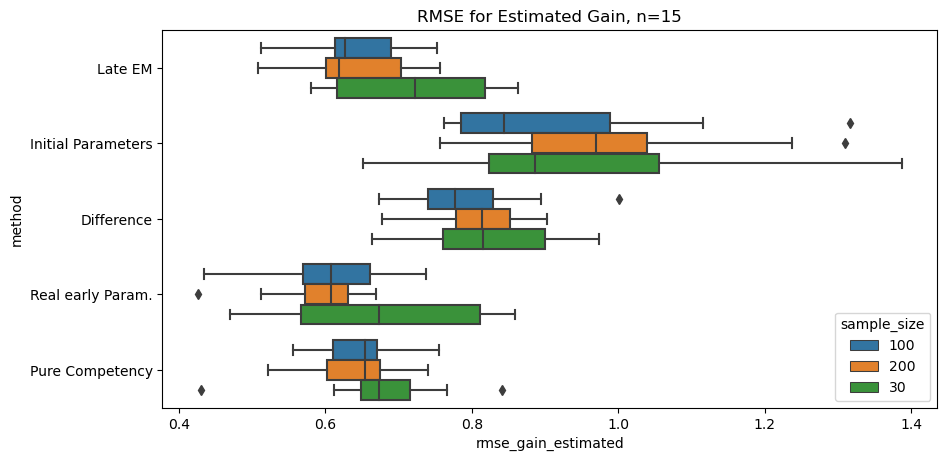

In [26]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

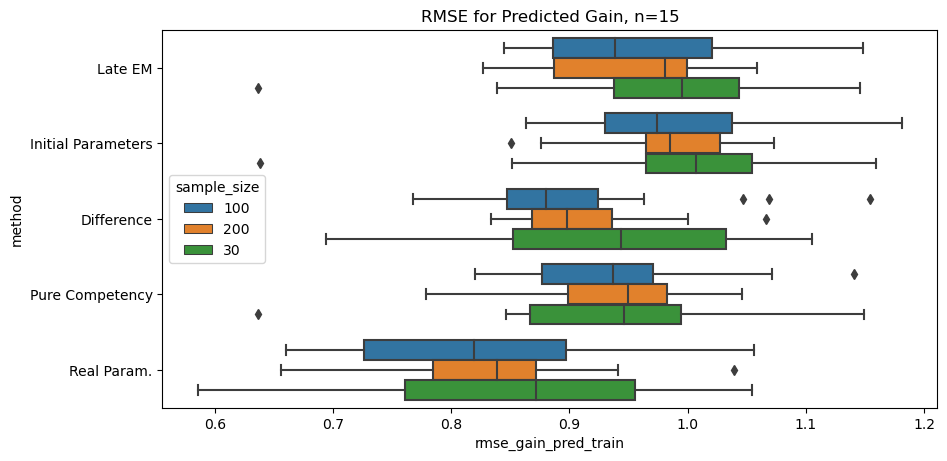

In [27]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Predicted Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [28]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, n=9}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  1.147 &       1.193 &       0.090 &  2.793 &       2.759 &       0.148 &   0.265 \\
    & \textbf{Initial Parameters} &  0.999 &       0.530 &       0.110 &  1.262 &       1.489 &       0.390 &   0.289 \\
    & \textbf{Late EM} &  1.160 &       1.214 &       0.036 &  4.232 &       3.668 &       0.189 &   0.352 \\
    & \textbf{Pure Competency} &  1.162 &       1.329 &       0.243 &  3.335 &       3.560 &       0.241 &   0.248 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &   

/tmp/ipykernel_9483/1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.147       1.193       0.090  2.793   
            Initial Parameters  0.999       0.530       0.110  1.262   
            Late EM             1.160       1.214       0.036  4.232   
            Pure Competency     1.162       1.329       0.243  3.335   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  4.918   
100         Difference          0.519       0.471       0.052  0.691   
            Initial Parameters  1.024       0.482       0.106  1.372   
            Late EM             0.512       0.463       0.050  0.914   
            Pure Competency     0.514       0.462       0.279  0.972   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.900   
200         Difference          0.365       0.237       0.034  0.396   
            Initial Parameters  1.069       0.437       0.108  1.269   
            Late EM             0.397       0.245       0.035  0.379   
            Pure Competency     0.348       0.238       0.267  0.425   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.412   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.759       0.148   0.265  
            Initial Parameters       1.489       0.390   0.289  
            Late EM                  3.668       0.189   0.352  
            Pure Competency          3.560       0.241   0.248  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        3.192       0.146   0.335  
100         Difference               0.831       0.100   0.143  
            Initial Parameters       1.662       0.348   0.336  
            Late EM                  1.049       0.194   0.373  
            Pure Competency          1.272       0.199   0.310  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        1.006       0.152   0.254  
200         Difference               0.365       0.110   0.217  
            Initial Parameters       1.358       0.273   0.365  
            Late EM                  0.931       0.250   0.288  
            Pure Competency          0.783       0.140   0.298  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.592       0.214   0.295

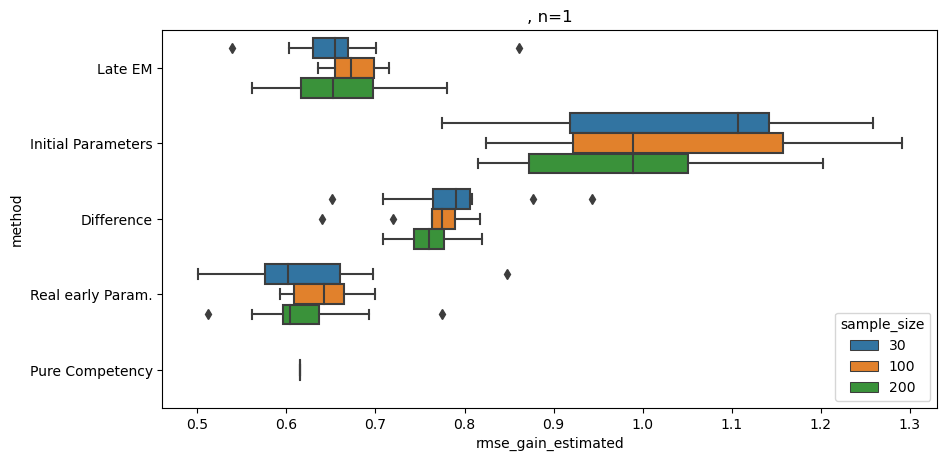

In [13]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

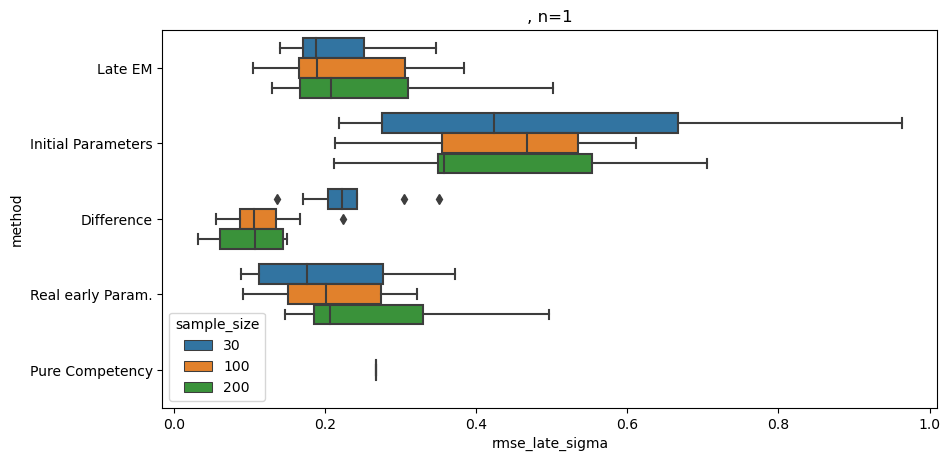

In [14]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

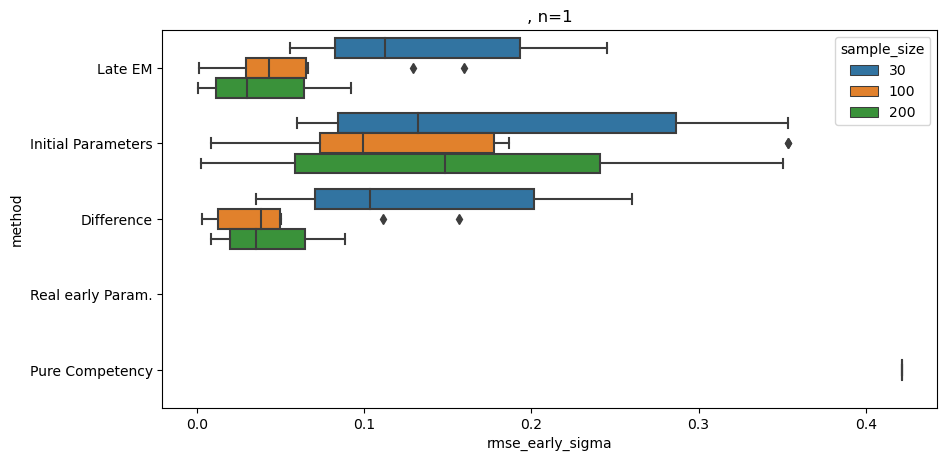

In [15]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [29]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, n=15}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &   $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &         &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  2.417 &       1.688 &       0.060 &   5.195 &       4.040 &       0.204 &   0.250 \\
    & \textbf{Initial Parameters} &  1.236 &       0.596 &       0.157 &   1.331 &       1.612 &       0.455 &   0.389 \\
    & \textbf{Late EM} &  2.488 &       1.646 &       0.077 &  11.707 &       5.607 &       0.205 &   0.295 \\
    & \textbf{Pure Competency} &  2.367 &       1.523 &       0.196 &   9.991 &       5.367 &       0.202 &   0.285 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &   0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf

/tmp/ipykernel_9483/1830420492.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$   $A^l$  \
Sample size Method                                                      
30          Difference          2.417       1.688       0.060   5.195   
            Initial Parameters  1.236       0.596       0.157   1.331   
            Late EM             2.488       1.646       0.077  11.707   
            Pure Competency     2.367       1.523       0.196   9.991   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   8.913   
100         Difference          0.647       0.459       0.066   0.921   
            Initial Parameters  1.217       0.540       0.101   1.356   
            Late EM             0.582       0.468       0.065   1.252   
            Pure Competency     0.591       0.453       0.278   1.601   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   1.118   
200         Difference          0.517       0.344       0.057   0.512   
            Initial Parameters  1.376       0.547       0.151   1.369   
            Late EM             0.504       0.320       0.044   0.663   
            Pure Competency     0.485       0.322       0.202   0.510   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   0.504   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               4.040       0.204   0.250  
            Initial Parameters       1.612       0.455   0.389  
            Late EM                  5.607       0.205   0.295  
            Pure Competency          5.367       0.202   0.285  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        5.033       0.162   0.311  
100         Difference               0.888       0.130   0.188  
            Initial Parameters       1.677       0.405   0.267  
            Late EM                  1.009       0.186   0.219  
            Pure Competency          1.436       0.332   0.249  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.915       0.176   0.237  
200         Difference               0.634       0.098   0.199  
            Initial Parameters       1.554       0.374   0.344  
            Late EM                  0.693       0.242   0.288  
            Pure Competency          0.614       0.217   0.299  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.598       0.220   0.310

In [30]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=6}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.259 &  0.292 &  0.348 &  0.349 \\
    & \textbf{Initial Parameters} &  0.371 &  0.372 &  0.324 &  0.388 \\
    & \textbf{Late EM} &  0.256 &  0.257 &  0.319 &  0.372 \\
    & \textbf{Pure Competency} &  0.291 &  0.301 &  0.237 &  0.366 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.295 &  0.285 &  0.333 &  0.480 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.240 &  0.220 &  0.264 &  0.264 \\
    & \textbf{Initial Parameters} &  0.333 &  0.359 &  0.266 &  0.281 \\
    & \textbf{Late EM} &  0.331 &  0.287 & 

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.259  0.292  0.348  0.349
            Initial Parameters  0.371  0.372  0.324  0.388
            Late EM             0.256  0.257  0.319  0.372
            Pure Competency     0.291  0.301  0.237  0.366
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.295  0.285  0.333  0.480
100         Difference          0.240  0.220  0.264  0.264
            Initial Parameters  0.333  0.359  0.266  0.281
            Late EM             0.331  0.287  0.262  0.285
            Pure Competency     0.334  0.347  0.242  0.257
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.330  0.288  0.289  0.278
200         Difference          0.301  0.391  0.355  0.293
            Initial Parameters  0.308  0.377  0.292  0.346
            Late EM             0.252  0.335  0.305  0.348
            Pure Competency     0.241  0.302  0.280  0.312
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.253  0.379  0.334  0.336

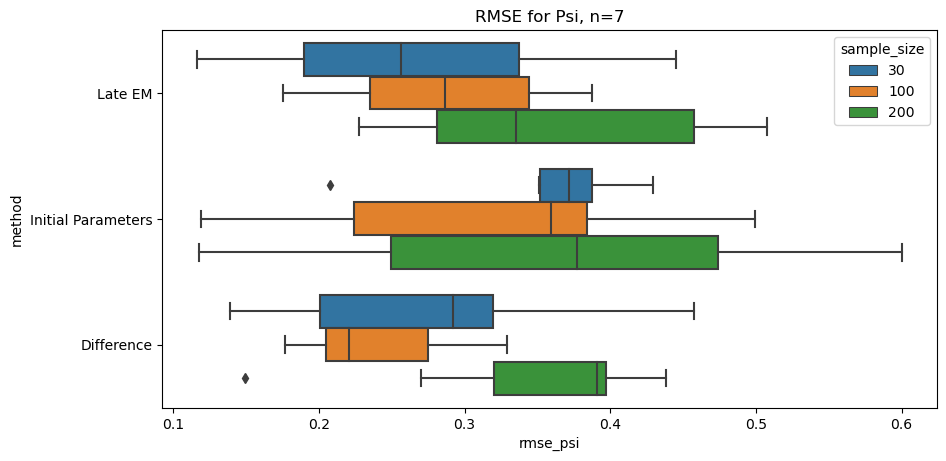

In [32]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [33]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$")

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.595 &  0.474 &  0.671 &  0.523 \\
    & \textbf{Initial Parameters} &  0.568 &  0.519 &  0.648 &  0.560 \\
    & \textbf{Late EM} &  0.580 &  0.479 &  0.670 &  0.532 \\
    & \textbf{Pure Competency} &  0.597 &  0.484 &  0.681 &  0.552 \\
    & \textbf{Real Param.} &  0.515 &  0.444 &  0.591 &  0.469 \\
    & \textbf{Real early Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.567 &  0.423 &  0.626 &  0.513 \\
    & \textbf{Initial Parameters} &  0.586 &  0.482 &  0.638 &  0.555 \\
    & \textbf{Late EM} &  0.

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.595  0.474  0.671  0.523
            Initial Parameters  0.568  0.519  0.648  0.560
            Late EM             0.580  0.479  0.670  0.532
            Pure Competency     0.597  0.484  0.681  0.552
            Real Param.         0.515  0.444  0.591  0.469
            Real early Param.   0.000  0.000  0.000  0.000
100         Difference          0.567  0.423  0.626  0.513
            Initial Parameters  0.586  0.482  0.638  0.555
            Late EM             0.571  0.435  0.632  0.508
            Pure Competency     0.578  0.432  0.633  0.517
            Real Param.         0.547  0.414  0.607  0.490
            Real early Param.   0.000  0.000  0.000  0.000
200         Difference          0.568  0.438  0.612  0.504
            Initial Parameters  0.597  0.502  0.644  0.563
            Late EM             0.574  0.442  0.611  0.511
            Pure Competency     0.552  0.445  0.627  0.530
            Real Param.         0.548  0.439  0.598  0.495
            Real early Param.   0.000  0.000  0.000  0.000

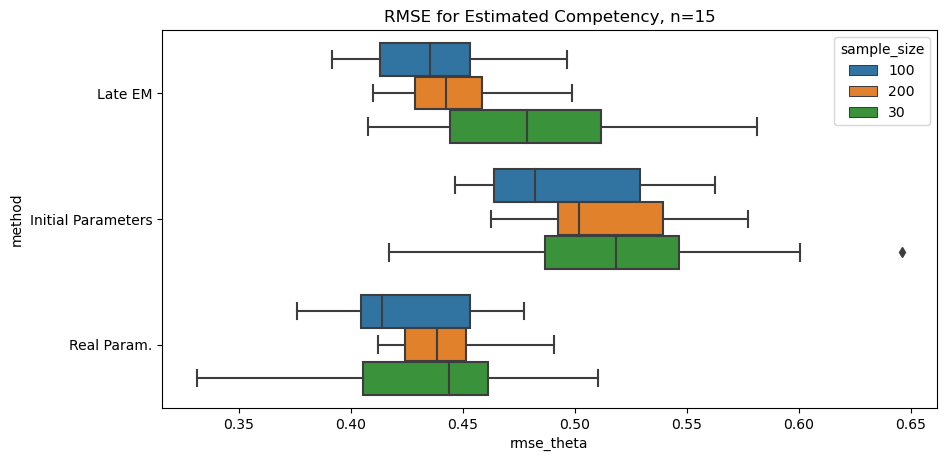

In [34]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters"], title="RMSE for Estimated Competency")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [35]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.838 &  0.815 &  0.910 &  0.889 \\
    & \textbf{Initial Parameters} &  0.929 &  0.886 &  0.963 &  1.039 \\
    & \textbf{Late EM} &  0.767 &  0.722 &  0.848 &  0.764 \\
    & \textbf{Pure Competency} &  0.758 &  0.673 &  0.822 &  0.757 \\
    & \textbf{Real Param.} &  0.542 &  0.488 &  0.586 &  0.522 \\
    & \textbf{Real early Param.} &  0.718 &  0.673 &  0.814 &  0.749 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.860 &  0.777 &  0.871 &  0.895 \\
    & \textbf{Initial Parameters} &  0.847 &  0.844 &  0.942 &  0.961 \\
    & \textbf{Late EM} &  0.

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.838  0.815  0.910  0.889
            Initial Parameters  0.929  0.886  0.963  1.039
            Late EM             0.767  0.722  0.848  0.764
            Pure Competency     0.758  0.673  0.822  0.757
            Real Param.         0.542  0.488  0.586  0.522
            Real early Param.   0.718  0.673  0.814  0.749
100         Difference          0.860  0.777  0.871  0.895
            Initial Parameters  0.847  0.844  0.942  0.961
            Late EM             0.769  0.627  0.853  0.762
            Pure Competency     0.744  0.655  0.820  0.723
            Real Param.         0.568  0.480  0.589  0.515
            Real early Param.   0.729  0.608  0.816  0.735
200         Difference          0.841  0.814  0.891  0.906
            Initial Parameters  0.918  0.969  0.969  1.048
            Late EM             0.749  0.619  0.825  0.720
            Pure Competency     0.732  0.654  0.788  0.717
            Real Param.         0.553  0.505  0.586  0.508
            Real early Param.   0.732  0.608  0.778  0.691

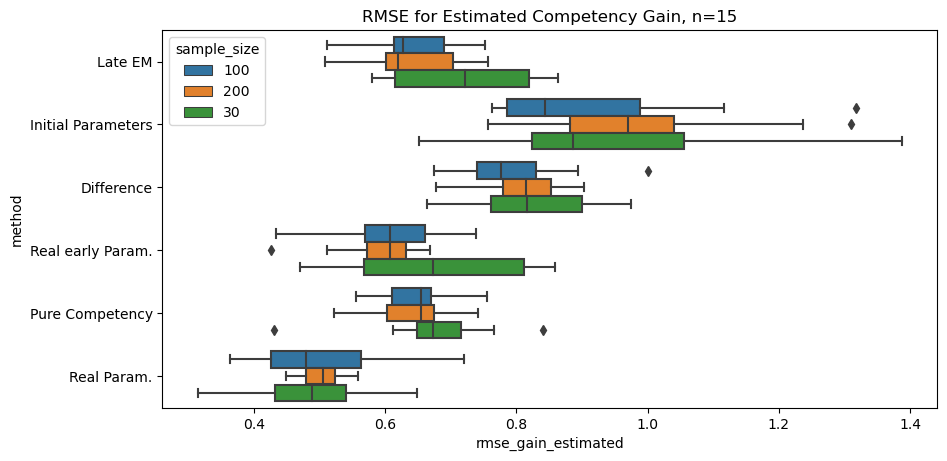

In [36]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="RMSE for Estimated Competency Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [37]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, n=13}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.893 &  0.944 &  1.032 &  0.931 \\
    & \textbf{Initial Parameters} &  0.928 &  1.007 &  1.007 &  0.972 \\
    & \textbf{Late EM} &  0.929 &  0.995 &  1.013 &  1.025 \\
    & \textbf{Pure Competency} &  0.916 &  0.946 &  1.012 &  0.961 \\
    & \textbf{Real Param.} &  0.736 &  0.872 &  0.844 &  0.824 \\
    & \textbf{Real early Param.} &  0.911 &  1.002 &  1.052 &  1.034 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.935 &  0.880 &  1.024 &  0.963 \\
    & \textbf{Initial Parameters} &  0.996 &  0.974 &  1.052 &  1.019 \\
    & \textbf{Late EM} &  0.

/tmp/ipykernel_9483/1880327442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.893  0.944  1.032  0.931
            Initial Parameters  0.928  1.007  1.007  0.972
            Late EM             0.929  0.995  1.013  1.025
            Pure Competency     0.916  0.946  1.012  0.961
            Real Param.         0.736  0.872  0.844  0.824
            Real early Param.   0.911  1.002  1.052  1.034
100         Difference          0.935  0.880  1.024  0.963
            Initial Parameters  0.996  0.974  1.052  1.019
            Late EM             0.995  0.938  1.062  1.050
            Pure Competency     0.951  0.937  1.015  1.022
            Real Param.         0.840  0.819  0.902  0.880
            Real early Param.   0.964  0.944  1.052  1.074
200         Difference          0.940  0.898  0.994  0.976
            Initial Parameters  0.989  0.985  1.037  1.040
            Late EM             0.960  0.981  1.040  1.052
            Pure Competency     0.940  0.949  1.017  1.019
            Real Param.         0.838  0.839  0.859  0.857
            Real early Param.   0.973  0.964  1.043  1.073

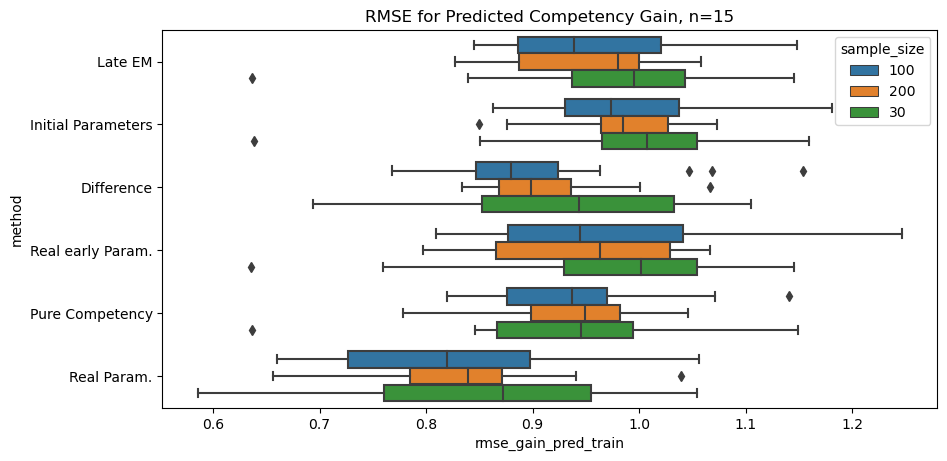

In [38]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="RMSE for Predicted Competency Gain",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

In [55]:
np.random.exponential(scale=0.5, size=10) + 1

array([1.26397031, 2.16157943, 1.09884415, 1.3479789 , 1.24689207,
       1.02586806, 1.02747325, 1.33341227, 1.18010599, 1.11716459])

### CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

In [39]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [40]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [41]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Train_06-28-21/Train/early.csv'

In [ ]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [42]:
V.shape

NameError: name 'V' is not defined

In [31]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [32]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]

In [33]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4044]
 [0.4044 1.    ]]
Step: 2: current parameter_diff: 7.291179527172233, current marginal loglikelihood: -5618.647896664741
EM Iteration 3
Current Monte Carlo Sample size: 300
[[1.     0.3166]
 [0.3166 1.    ]]
Step: 3: current parameter_diff: 3.7225723508498363, current marginal loglikelihood: -5608.540451734756
EM Iteration 4
Current Monte Carlo Sample size: 300
[[0.9999 0.2647]
 [0.2647 0.9999]]
Step: 4: current parameter_diff: 2.647591704499762, current marginal loglikelihood: -5592.725245320151
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[0.9999 0.2688]
 [0.2688 1.    ]]
Step: 5: current parameter_diff: 1.385698317295841, current marginal loglikelihood: -5593.4492562841415
EM Iteration 6
Current Monte Carlo Sample size: 324
[[1.     0.2338]
 [0.2338 1.    ]]
Step: 6: current parameter_diff: 1.9128060105384799, current marginal loglikelihood: -5586.940920659123
EM Iteration 7
Current Monte Carlo Sample size: 349
[[1.     0.2563]
 [0.2563 0.9999]]
Step: 7: current parameter_diff: 0.5205668819087325, current marginal loglikelihood: -5584.632448511162
EM Iteration 8
Current Monte Carlo Sample size: 376
[[1.     0.2635]
 [0.2635 1.    ]]
Step: 8: current parameter_diff: 1.727449668969668, current marginal loglikelihood: -5586.788598168227
EM Iteration 9
Current Monte Carlo Sample size: 406
[[1.     0.2424]
 [0.2424 0.9999]]
Step: 9: current parameter_diff: 1.4240857783098242, current marginal loglikelihood: -5581.384353555039


In [34]:
# Estimate the Late Variance


In [35]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.ones(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    logit=True, sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.01, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[ 1.      0.2424 -0.1983 -0.2456]
 [ 0.2424  0.9999 -0.2478 -0.1917]
 [-0.1983 -0.2478  0.6511  0.3276]
 [-0.2456 -0.1917  0.3276  0.6397]]
Step: 2: current parameter_diff: 13.182346411020225, current marginal loglikelihood: -4366.86993126403
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[ 1.      0.2424 -0.1581 -0.2488]
 [ 0.2424  0.9999 -0.2345 -0.158 ]
 [-0.1581 -0.2345  0.6933  0.3615]
 [-0.2488 -0.158   0.3615  0.687 ]]
Step: 3: current parameter_diff: 10.09386425407526, current marginal loglikelihood: -4329.191744994684
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[ 1.      0.2424 -0.1499 -0.2419]
 [ 0.2424  0.9999 -0.2174 -0.1534]
 [-0.1499 -0.2174  0.6885  0.3409]
 [-0.2419 -0.1534  0.3409  0.6798]]
Step: 4: current parameter_diff: 5.4656022298911, current marginal loglikelihood: -4282.878828595035
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[ 1.      0.2424 -0.1623 -0.247 ]
 [ 0.2424  0.9999 -0.2436 -0.1609]
 [-0.1623 -0.2436  0.6936  0.3429]
 [-0.247  -0.1609  0.3429  0.692 ]]
Step: 5: current parameter_diff: 3.1346570332824104, current marginal loglikelihood: -4258.516436414066
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[ 1.      0.2424 -0.1539 -0.2501]
 [ 0.2424  0.9999 -0.2262 -0.162 ]
 [-0.1539 -0.2262  0.6846  0.3474]
 [-0.2501 -0.162   0.3474  0.6926]]
Step: 6: current parameter_diff: 2.3849649930821637, current marginal loglikelihood: -4257.602959394992
EM Iteration 7


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[ 1.      0.2424 -0.153  -0.243 ]
 [ 0.2424  0.9999 -0.2289 -0.1611]
 [-0.153  -0.2289  0.6828  0.3529]
 [-0.243  -0.1611  0.3529  0.6876]]
Step: 7: current parameter_diff: 2.795921914579703, current marginal loglikelihood: -4242.701513973824


### Item Parameters

In [36]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [37]:
shift = -1*np.quantile(s_hat, q=0.25, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [38]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [39]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.834 &     0.000 &    1.659 \\
\textbf{1 } &   1.0 &       0.0 &  1.210 &     0.000 &    1.276 \\
\textbf{2 } &   1.0 &       0.0 &  0.912 &     0.000 &    1.271 \\
\textbf{3 } &   1.0 &       0.0 &  0.777 &     0.000 &    1.307 \\
\textbf{4 } &   1.0 &       0.0 &  1.235 &     0.000 &    1.285 \\
\textbf{5 } &   1.0 &       0.0 &  1.517 &     0.000 &    1.517 \\
\textbf{6 } &   1.0 &       0.0 &  0.996 &     0.000 &    1.166 \\
\textbf{7 } &   1.0 &       0.0 &  0.800 &     0.000 &    1.305 \\
\textbf{8 } &   1.0 &       0.0 &  0.997 &     0.000 &    1.178 \\
\textbf{9 } &   1.0 &       0.0 &  1.376 &     0.000 &    1.200 \\
\textbf{10} &   1.0 &       0.0 &  1.173 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.834     0.000    1.659
1             1.0       0.0  1.210     0.000    1.276
2             1.0       0.0  0.912     0.000    1.271
3             1.0       0.0  0.777     0.000    1.307
4             1.0       0.0  1.235     0.000    1.285
5             1.0       0.0  1.517     0.000    1.517
6             1.0       0.0  0.996     0.000    1.166
7             1.0       0.0  0.800     0.000    1.305
8             1.0       0.0  0.997     0.000    1.178
9             1.0       0.0  1.376     0.000    1.200
10            1.0       0.0  1.173     0.000    1.427
11            1.0       0.0  1.174     0.000    1.588
12            1.0       0.0  1.145     0.000    1.484
13            1.0       0.0  1.316     0.000    1.484
14            1.0       0.0  1.004     0.000    1.167
15            1.0       0.0  1.097     0.000    0.773
16            1.0       0.0  1.162     0.000    1.262
17            1.0       0.0  1.123     0.000    1.142
18            1.0       1.0  1.176     0.674    0.282
19            1.0       0.0  0.835     0.000    0.656
20            0.0       1.0  0.000     2.249    1.439
21            1.0       1.0  0.067     2.879    1.346
22            1.0       1.0  0.307     1.551    0.991
23            1.0       1.0  0.450     1.625    1.001
24            1.0       1.0  1.124     1.251    1.525
25            1.0       0.0  0.875     0.000    1.096
26            1.0       1.0  0.535     1.284    0.517
27            1.0       1.0  0.905     1.295    1.212
28            1.0       1.0  0.727     0.754    0.888
29            1.0       1.0  0.692     1.505    0.965

In [40]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.345 &    1.211 \\
\textbf{1 } &   1.0 &       1.0 &  0.972 &     0.718 &    1.013 \\
\textbf{2 } &   1.0 &       1.0 &  1.293 &     0.108 &    1.896 \\
\textbf{3 } &   1.0 &       1.0 &  0.856 &     1.412 &    0.745 \\
\textbf{4 } &   1.0 &       1.0 &  1.233 &     0.591 &    0.857 \\
\textbf{5 } &   1.0 &       1.0 &  0.716 &     0.548 &    0.839 \\
\textbf{6 } &   1.0 &       1.0 &  0.853 &     0.706 &    0.555 \\
\textbf{7 } &   1.0 &       1.0 &  0.190 &     1.145 &    0.834 \\
\textbf{8 } &   1.0 &       1.0 &  0.733 &     1.991 &    0.717 \\
\textbf{9 } &   1.0 &       1.0 &  0.116 &     1.113 &    0.143 \\
\textbf{10} &   1.0 &       1.0 &  0.849 &     0.935

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.345    1.211
1             1.0       1.0  0.972     0.718    1.013
2             1.0       1.0  1.293     0.108    1.896
3             1.0       1.0  0.856     1.412    0.745
4             1.0       1.0  1.233     0.591    0.857
5             1.0       1.0  0.716     0.548    0.839
6             1.0       1.0  0.853     0.706    0.555
7             1.0       1.0  0.190     1.145    0.834
8             1.0       1.0  0.733     1.991    0.717
9             1.0       1.0  0.116     1.113    0.143
10            1.0       1.0  0.849     0.935    0.688
11            1.0       1.0  0.327     1.872    1.155
12            1.0       1.0  0.341     1.266    0.829
13            1.0       1.0  0.432     0.974    0.930
14            0.0       1.0  0.000     1.073    1.572
15            1.0       1.0  0.056     1.762    1.047
16            1.0       1.0  0.280     1.617    0.257
17            1.0       1.0  0.474     1.038    0.657
18            0.0       1.0  0.000     1.551    0.983
19            0.0       1.0  0.000     1.452    1.148

(array([[  1.,   5.,  20.,  57.,  83., 121.,  64.,  15.,   1.,   0.],
        [  2.,   5.,  29.,  47.,  72.,  73.,  93.,  32.,  11.,   3.]]),
 array([-1.66390287, -1.26021727, -0.85653167, -0.45284608, -0.04916048,
         0.35452512,  0.75821071,  1.16189631,  1.56558191,  1.9692675 ,
         2.3729531 ]),
 <a list of 2 BarContainer objects>)

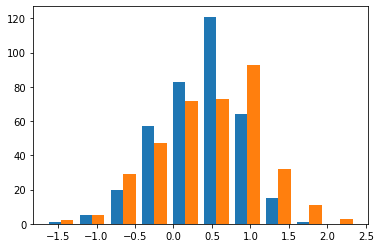

In [42]:
plt.hist(s_hat_shift)

### Person Parameters

In [43]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [44]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [46]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.242 &          -0.153 &    -0.243 &  0.000 \\
                & \textbf{Iteration} &            0.242 &     1.000 &          -0.229 &    -0.161 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &           -0.153 &    -0.229 &           0.683 &     0.353 &  0.596 \\
                & \textbf{Iteration} &           -0.243 &    -0.161 &           0.353 &     0.688 &  0.764 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_3204\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.242          -0.153   
                 Iteration              0.242     1.000          -0.229   
Competence Gain  Logic                 -0.153    -0.229           0.683   
                 Iteration             -0.243    -0.161           0.353   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic          -0.243  0.000  
                 Iteration      -0.161  0.000  
Competence Gain  Logic           0.353  0.596  
                 Iteration       0.688  0.764

# Gain Visualization

In [103]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [104]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [109]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.95,-0.19,0.44,0.57,-0.51,0.37
0.50,-0.20,-0.03,0.32,0.39,0.12,0.36
0.75,0.33,-0.02,0.34,0.43,0.67,0.41
1.00,1.11,0.42,0.30,0.46,1.41,0.88


In [55]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [79]:
theta_hat[np.argsort(theta_hat[:,0])]

array([[-2.51204267e+00, -8.08001251e-01],
       [-2.37179512e+00, -1.54247459e+00],
       [-2.26955198e+00, -1.54759463e+00],
       [-2.16089953e+00, -1.55394048e+00],
       [-1.98373826e+00, -8.13255289e-01],
       [-1.77844857e+00, -1.15340706e+00],
       [-1.77139918e+00, -1.58474829e+00],
       [-1.66832914e+00, -2.18772843e-01],
       [-1.55817274e+00, -3.43022961e-01],
       [-1.45810640e+00,  2.97300150e-01],
       [-1.39382200e+00, -2.77069105e-01],
       [-1.38220880e+00,  5.31400377e-01],
       [-1.30305617e+00,  1.05611246e+00],
       [-1.26041016e+00, -5.34166743e-01],
       [-1.25279671e+00,  6.84999148e-01],
       [-1.23679706e+00,  3.39353769e-01],
       [-1.23355152e+00,  4.31648326e-01],
       [-1.15782265e+00, -3.21743990e-01],
       [-1.15187778e+00, -6.36495204e-01],
       [-1.13649077e+00, -1.66421714e+00],
       [-1.13287064e+00, -1.04500014e+00],
       [-1.10070036e+00,  1.00232119e+00],
       [-1.08461889e+00,  1.41957558e-01],
       [-1.

In [84]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

In [85]:
theta_logic_quantiles

[array([[-2.51204267, -0.80800125],
        [-2.37179512, -1.54247459],
        [-2.26955198, -1.54759463],
        [-2.16089953, -1.55394048],
        [-1.98373826, -0.81325529],
        [-1.77844857, -1.15340706],
        [-1.77139918, -1.58474829],
        [-1.66832914, -0.21877284],
        [-1.55817274, -0.34302296],
        [-1.4581064 ,  0.29730015]]),
 array([[-1.393822  , -0.27706911],
        [-1.3822088 ,  0.53140038],
        [-1.30305617,  1.05611246],
        [-1.26041016, -0.53416674],
        [-1.25279671,  0.68499915],
        [-1.23679706,  0.33935377],
        [-1.23355152,  0.43164833],
        [-1.15782265, -0.32174399],
        [-1.15187778, -0.6364952 ],
        [-1.13649077, -1.66421714]]),
 array([[-1.13287064e+00, -1.04500014e+00],
        [-1.10070036e+00,  1.00232119e+00],
        [-1.08461889e+00,  1.41957558e-01],
        [-1.08156741e+00, -1.64113799e-01],
        [-1.06010362e+00,  9.91778070e-01],
        [-1.05472344e+00, -4.86328275e-01],
        [-1.